### 1 bit adder

We build the quantum adder circuit

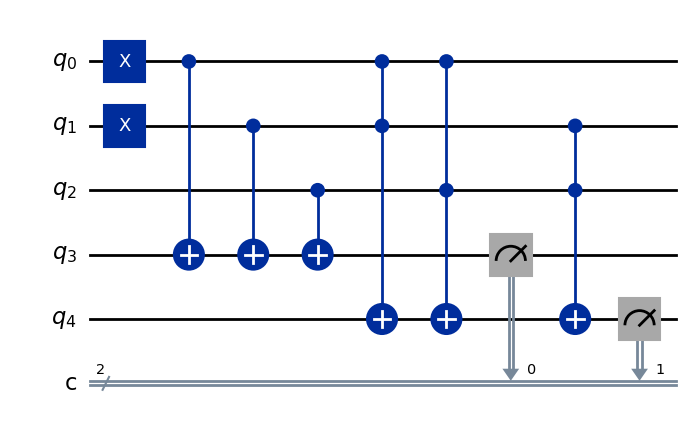

In [1]:
from qiskit import *

qc = QuantumCircuit(5,2)

qc.x(0) #bit 1 
qc.x(1) #bit 2
# qc.x(2) # carry bit

qc.cx(0,3)
qc.cx(1,3)
qc.cx(2,3)

qc.ccx(0,1,4)
qc.ccx(0,2,4)
qc.ccx(1,2,4)
qc.measure(3,0)
qc.measure(4,1)
qc.draw('mpl')

Now we run the Aer simulator

In [5]:
from qiskit_aer import AerSimulator
simulator_aer = AerSimulator()

result = simulator_aer.run(qc, shots = 3290).result()
counts_aer = result.get_counts()
print(counts_aer)

{'10': 3290}


Running on IBM hardware

In [4]:
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import transpile
from qiskit.circuit import parameter
from math import pi
from qiskit_ibm_runtime import SamplerV2, EstimatorV2, QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend_name = "ibm_brisbane"
backend = QiskitRuntimeService().backend(backend_name)
sampler_bane = SamplerV2(mode = backend)

pass_manager = generate_preset_pass_manager(optimization_level = 1, backend=backend)

qc_transcpiled = pass_manager.run(qc)
# qc_transcpiled.draw('mpl')

job = sampler_bane.run([qc_transcpiled])
job_result = job.result()

counts_ibm = job_result[0].data.c.get_counts()
print(counts_ibm)

{'01': 250, '10': 2757, '11': 358, '00': 731}


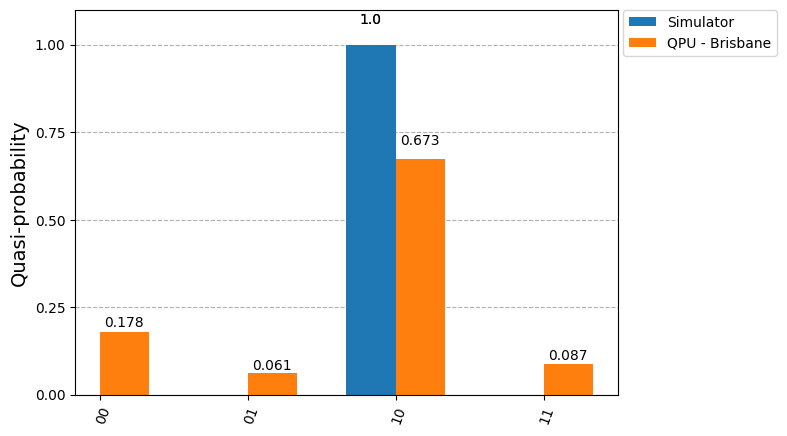

In [16]:
from qiskit.visualization import plot_distribution
plot_distribution([counts_aer, counts_ibm],
                  legend = ['Simulator', 'QPU - Brisbane'])

Since it doesn't show many errors, we are going to switch to 2 bits

### 2 bit adder

We build the quantum adder circuit, and add |ab> +|cd> = 

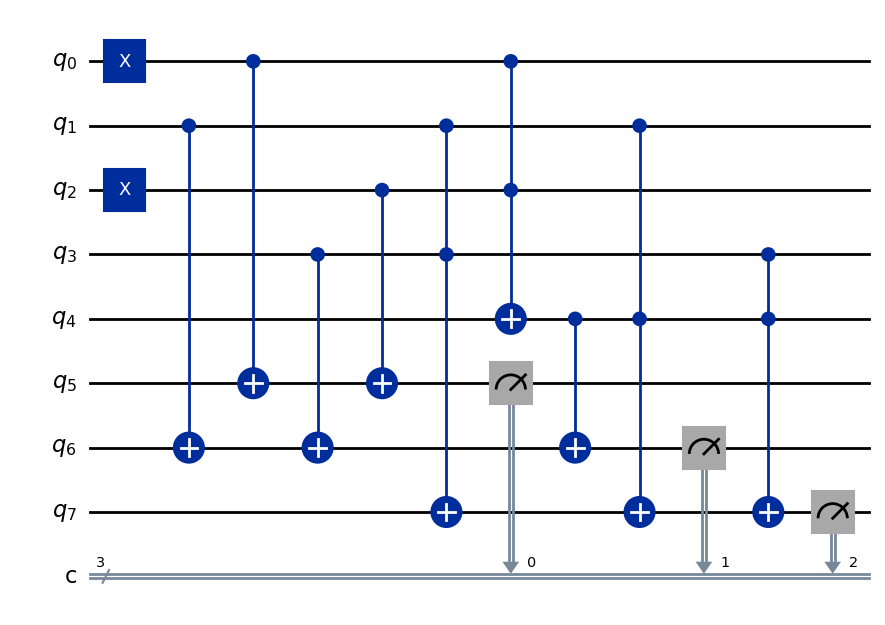

In [24]:
qc2 = QuantumCircuit(8,3)

qc2.x(0) #bit a
# qc2.x(1)  #bit b
qc2.x(2)  #bit d
# qc2.x(3) #bit c

# qc2.x(4)  #carry bit

qc2.cx(0,5)
qc2.cx(2,5)

qc2.ccx(0,2,4)
qc2.cx(1,6)
qc2.cx(3,6)
qc2.cx(4,6)

qc2.ccx(1,3,7)
qc2.ccx(1,4,7)
qc2.ccx(3,4,7)

qc2.measure(5,0)
qc2.measure(6,1)
qc2.measure(7,2)
qc2.draw('mpl')

In [25]:
result = simulator_aer.run(qc2, shots = 3290).result()
counts_aer = result.get_counts()
print(counts_aer)

{'010': 3290}


In [28]:
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import transpile
from qiskit.circuit import parameter
from math import pi
from qiskit_ibm_runtime import SamplerV2, EstimatorV2, QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend_name = "ibm_brisbane"
backend = QiskitRuntimeService().backend(backend_name)
sampler_bane = SamplerV2(mode = backend)

pass_manager = generate_preset_pass_manager(optimization_level = 1, backend=backend)

qc_transcpiled = pass_manager.run(qc2)
# qc_transcpiled.draw('mpl')

job = sampler_bane.run([qc_transcpiled])
job_result = job.result()

counts_ibm_error = job_result[0].data.c.get_counts()
print(counts_ibm_error)

{'100': 586, '001': 576, '111': 399, '110': 376, '011': 442, '010': 501, '101': 543, '000': 673}


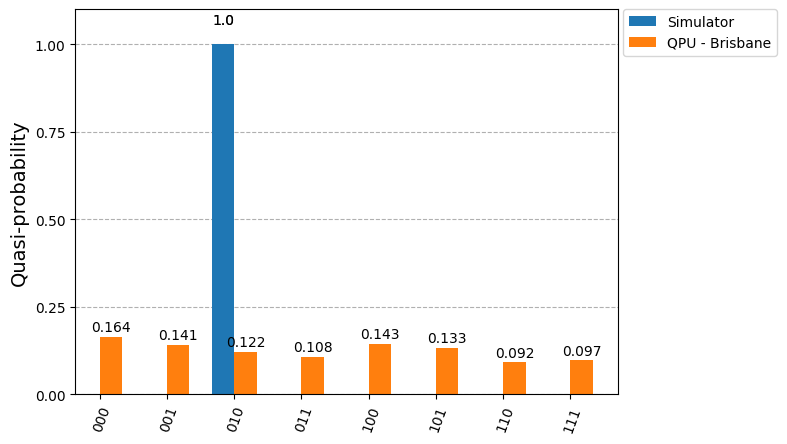

In [29]:
from qiskit.visualization import plot_distribution
plot_distribution([counts_aer, counts_ibm_error],
                  legend = ['Simulator', 'QPU - Brisbane'])

Now we see how the cicuit fails completely

### Error Correction

In [30]:
from qiskit import*
import qiskit.circuit.library as qulib

control_x1 = qulib.XGate().control(2, ctrl_state='01')
control_x2 = qulib.XGate().control(2, ctrl_state='10')

def encode_qubits(qc, a,b,c): # Encoding the qubits using cx gate |a> --> |00a>
    #qc is the quantum circuit
    #a,b,c are the bits for encoding
    
    qc.cx(a,b)
    qc.cx(a,c)

def error_correction(qc, a,b,c, p1,p2):
    #a,b,c are the bits for encoding
    # p1 and p2 are for parity check
    #Parity Check (Error Syndrome)
    qc.cx(a, p1)
    qc.cx(b, p1)
    qc.cx(b, p2)
    qc.cx(c, p2)

    #Creating custom gates for implementing multi control of qubitserror correction
    qc.ccx(p1, p2, b)  # Correct qubit 1 if needed
    qc.append(control_x1, [p1, p2, a])  # Conditional correction for qubit 0
    qc.append(control_x2, [p1, p2, c])  # Conditional correction for qubit 2

    #reset to 0 for reuse as parity
    qc.reset(p1)
    qc.reset(p2)
    qc.barrier() # to prevent gates flowing around

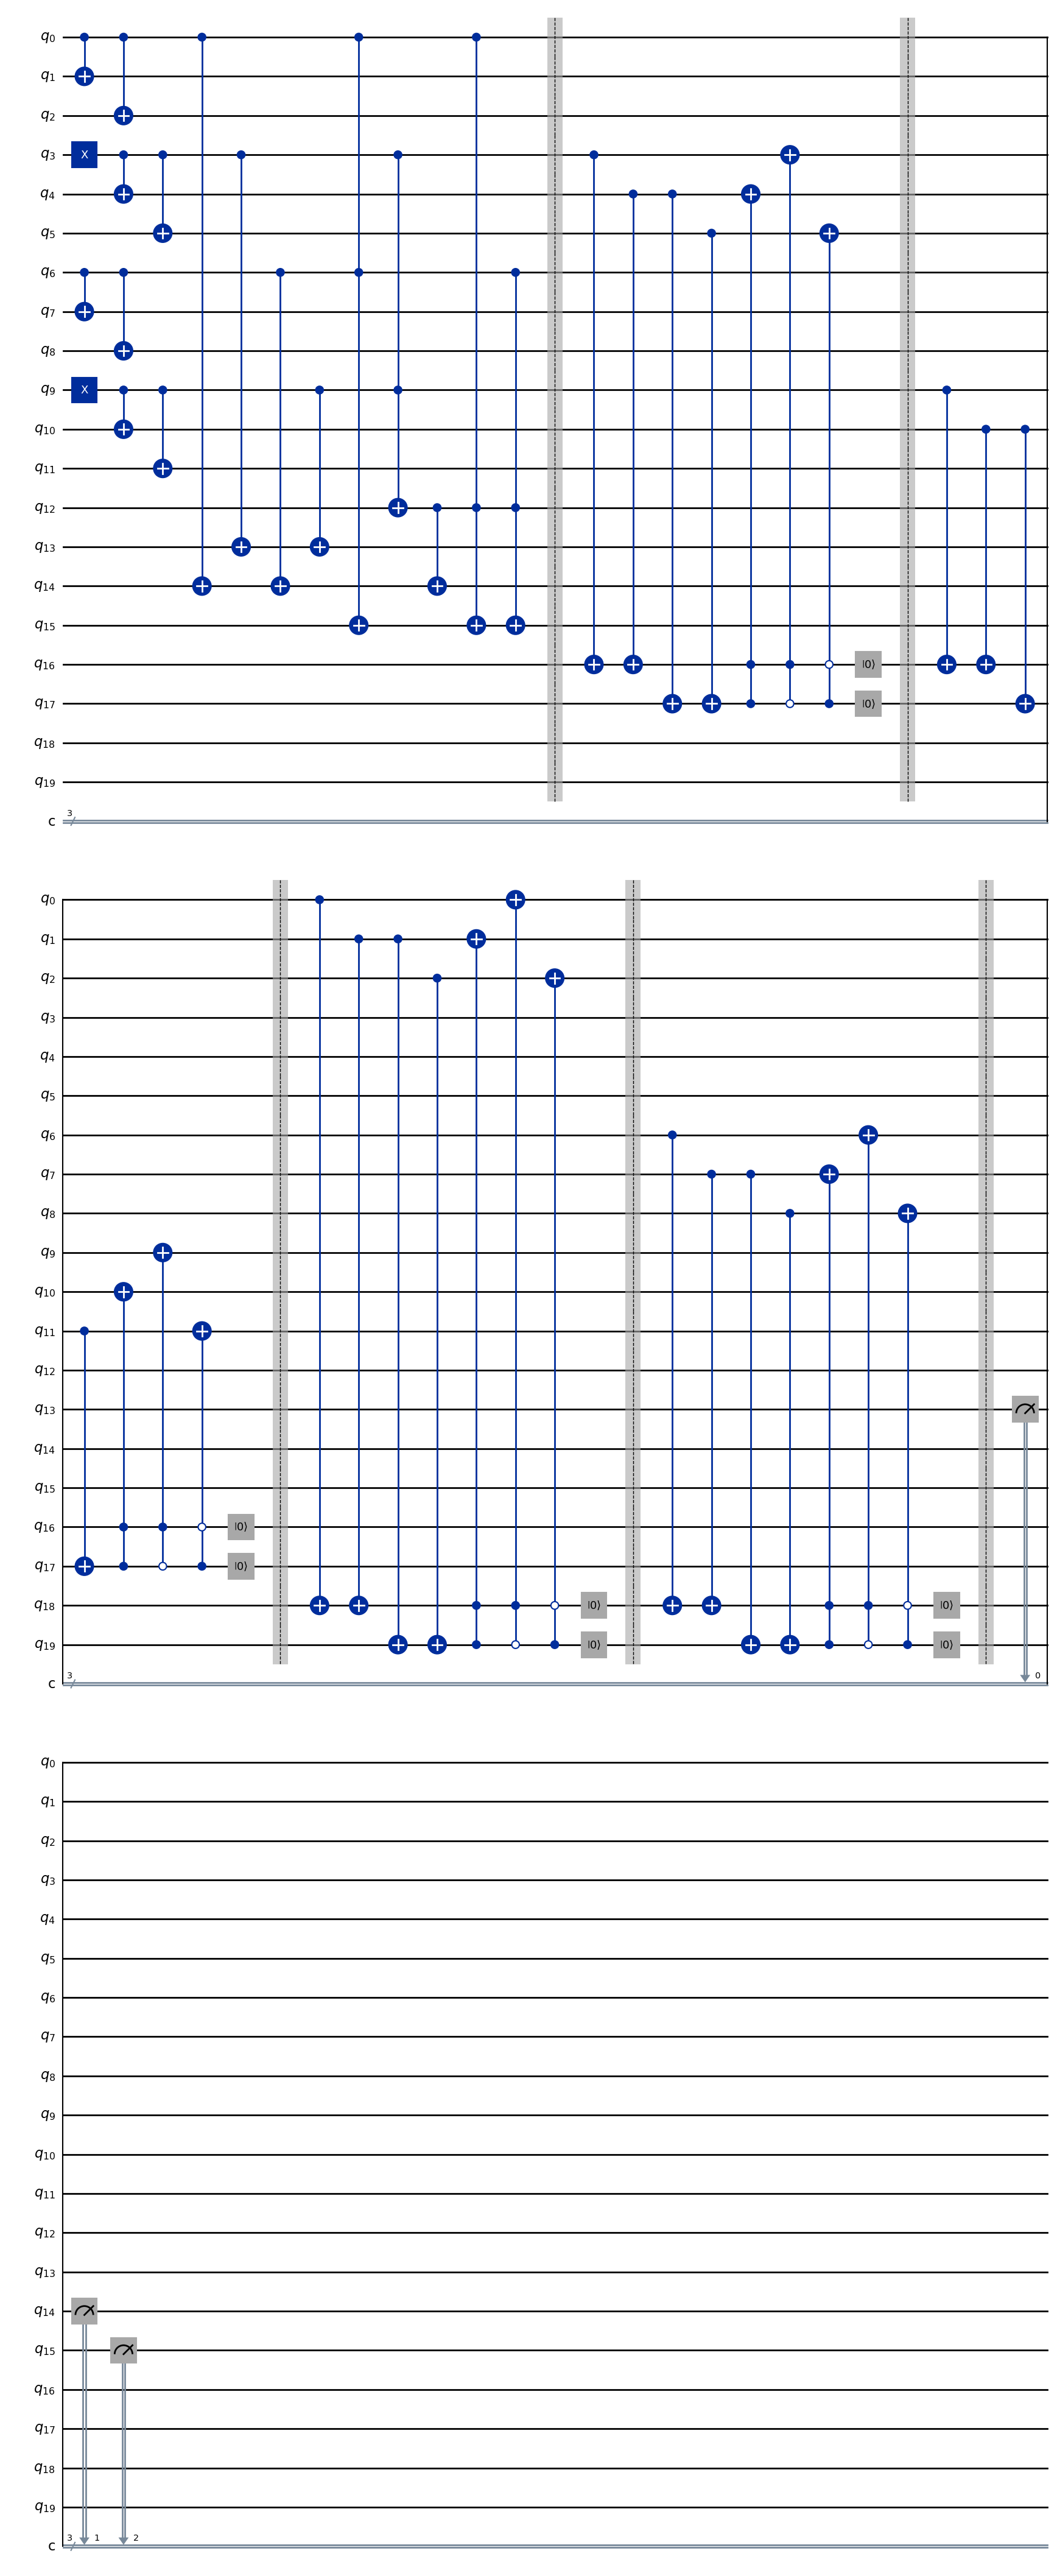

In [21]:
qc = QuantumCircuit(20,3)

#We will add |ab> + |cd>
# a - 0, encoding - 0,1,2
# b - 3, encoding - 3,4,5
# c - 6, encoding - 6,7,8
# d - 9, encoding - 9,10,11

#S1 - 13
#S2 - 14 
#C - 15
#C' temporary carry for b + d

#16 and 17 parity check for b and d
#18 and 19 parity check for b and d

#Step 1: Initializing qubits
qc.x(3) #|01>
qc.x(9) #|01>

#Step 2: Encoding qubits
encode_qubits(qc,0,1,2) #a
encode_qubits(qc,3,4,5) #b
encode_qubits(qc,6,7,8) #c
encode_qubits(qc,9,10,11) #d

#Step 3: Full adder logic

#|b> + |d> 
qc.cx(3,13) 
qc.cx(9,13)

#temporary carry
qc.ccx(3,9,12)

#|a> + |c> 
qc.cx(0,14)
qc.cx(6,14)

#add temporary carry
qc.cx(12,14)

# main carry controlled by a,c and temporary carry 
qc.ccx(0,6,15)
qc.ccx(0,12,15)
qc.ccx(6,12,15)

qc.barrier()

# Step 4: Parity check and error correction
error_correction(qc,3,4,5,16,17) #b
error_correction(qc,9,10,11,16,17) #d
error_correction(qc,0,1,2,18,19) #a
error_correction(qc,6,7,8,18,19) #c


#Measurement
qc.measure([13,14,15],[0,1,2])

#drawing the circuit
qc.draw('mpl')

In [18]:
#Simulation on Aer_Simulaotr
from qiskit_aer import AerSimulator
simulator_aer = AerSimulator()
result = simulator_aer.run(qc, shots = 3290).result()
counts_aer = result.get_counts()
print(counts_aer)

{'010': 3290}


In [19]:
#Running on IBM_Brisbane QPU
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import transpile
from qiskit.circuit import parameter
from math import pi
from qiskit_ibm_runtime import SamplerV2, EstimatorV2, QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#Specifying the QPU
backend_name = "ibm_brisbane"
backend = QiskitRuntimeService().backend(backend_name)

#Using sampler as a primitive
sampler_bane = SamplerV2(mode = backend)

#Transpilation of the circuit
pass_manager = generate_preset_pass_manager(optimization_level = 3, backend=backend)
qc_transcpiled = pass_manager.run(qc)

# Finally running the job
job = sampler_bane.run([qc_transcpiled])

#Obtaining the results
job_result = job.result()

# We are primarily concerned with counts
counts_ibm = job_result[0].data.c.get_counts()
print(counts_ibm)

{'000': 1461, '010': 915, '001': 598, '011': 346, '101': 132, '110': 188, '111': 75, '100': 381}


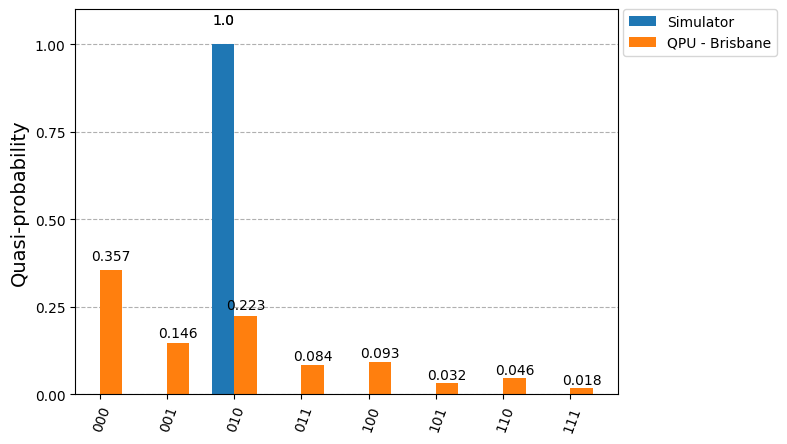

In [23]:
# Here we simply plot the grpah for camparision
from qiskit.visualization import plot_distribution
plot_distribution([counts_aer, counts_ibm],
                  legend = ['Simulator', 'QPU - Brisbane'])

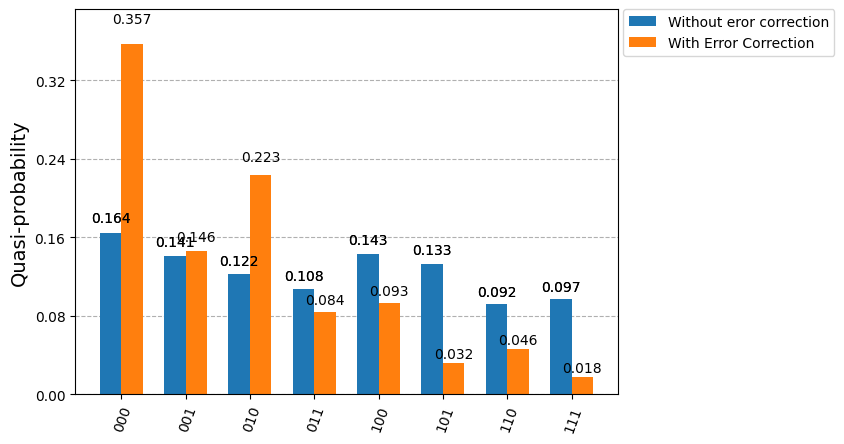

In [31]:
# Here we simply plot the grpah 
from qiskit.visualization import plot_distribution
plot_distribution([counts_ibm_error, counts_ibm],
                  legend = ['Without eror correction', 'With Error Correction'])